In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install library

In [ ]:
!unzip /content/drive/MyDrive/Breast_Cancer_Detection/data.zip

In [ ]:
!unzip /content/drive/MyDrive/Breast_Cancer_Detection/archive.zip 

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
!pip install tensorflow_addons 

In [ ]:
!pip install tf_clahe 

In [ ]:
# Install eficientnet-v2
#!pip install git+https://github.com/sebastian-sz/efficientnet-v2-keras@main

In [ ]:
#ConvNeXt
#!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
#ConvNeXt
#!git clone https://github.com/facebookresearch/ConvNeXt

In [ ]:
#ConvNext
#import sys
#if 'google.colab' in sys.modules:
#    print('Running in Colab.')
#    !pip3 install timm==0.5.4 

# Import library

In [7]:
import os
import cv2
import keras
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa




from tensorflow import keras
from tensorflow.python.client import device_lib
from packaging.version import parse
from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
from tensorflow.python.client import device_lib

In [8]:
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [9]:
print(tf.__version__)

2.11.0


In [10]:
#Set up CPU and GPU
def set_cpu_gpus(mixed_precision=True):
    try: 
        # printed out the detected devices
        list_ld = device_lib.list_local_devices()
        for dev in list_ld: print(dev.name,dev.memory_limit)
        physical_devices = tf.config.list_physical_devices(
            'GPU' if len(list_ld) - 1 else 'CPU'
        )
        # For GPU devices, set growth memory constraint
        if 'GPU' in physical_devices[-1]:
            tf.config.optimizer.set_jit(True)
            keras.mixed_precision.set_global_policy("mixed_float16")
            for pd in physical_devices:
                tf.config.experimental.set_memory_growth(pd, True)
        strategy = tf.distribute.MirroredStrategy()
        return (strategy, physical_devices)
    except: 
        raise ValueError('No Device Detected!')

In [11]:
def set_tpu(mixed_precision=True):
    try: 
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() 
        if mixed_precision:
            keras.mixed_precision.set_global_policy("mixed_bfloat16") 
        tf.config.set_soft_device_placement(True)
        strategy = tf.distribute.TPUStrategy(tpu)
        physical_devices = tf.config.list_logical_devices('TPU')
        return (strategy, physical_devices)
    except:
        False

In [12]:
strategy, physical_devices = set_tpu(mixed_precision=False) or set_cpu_gpus()
physical_devices, tf.__version__

/device:CPU:0 268435456
/device:GPU:0 40213086208


([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.11.0')

In [13]:
def make_plot(tfdata, figsize=(20, 20)):
    
    plt.figure(figsize=figsize)
    xy = int(np.ceil(tfdata.shape[0] * 0.5))

    for i in range(tfdata.shape[0]):
        plt.subplot(xy, xy, i + 1)
        plt.imshow(tf.cast(tfdata[i], dtype=tf.uint8))
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Load data

In [14]:
class Config:
    class data:
        fold=0
        batch_size=40
        resize_dim=1024
        aspect_ratio=True
        img_size=(1024, 512)
        

        base_path = '/content/drive/MyDrive/Breast_Cancer_Detection'
        
        path_to_train="/content/drive/MyDrive/Breast_Cancer_Detection/5_folds_data.csv"
        path_to_train_images="/content/data/"

In [15]:
df = pd.read_csv(Config.data.path_to_train)
print(f"train.shape = {df.shape}")

df.head()

train.shape = (54706, 15)


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,fold
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,1
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,1
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,1
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,1
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,0


In [16]:
df['img_path'] = f'{Config.data.path_to_train_images}' + '/' + df['patient_id'].astype(str) + '_' + df['image_id'].astype(str) + '.png'


display(df.head(2))
display(df['img_path'][0])

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,fold,img_path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,1,/content/data//10006_462822612.png
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,1,/content/data//10006_1459541791.png


'/content/data//10006_462822612.png'

In [17]:
df.cancer.value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

In [18]:
df.groupby(['fold', "cancer"]).size()

fold  cancer
0     0         10746
      1           233
1     0         10644
      1           235
2     0         10763
      1           249
3     0         10670
      1           221
4     0         10725
      1           220
dtype: int64

In [19]:
train_df = df.query(f'fold != {Config.data.fold}').reset_index(drop=True)
valid_df = df.query(f'fold == {Config.data.fold}').reset_index(drop=True)

train_df.shape, valid_df.shape

((43727, 16), (10979, 16))

In [20]:
print(train_df.patient_id.nunique())
print(train_df.cancer.value_counts(normalize=True))

print(valid_df.patient_id.nunique())
print(valid_df.cancer.value_counts(normalize=True))

9530
0    0.978846
1    0.021154
Name: cancer, dtype: float64
2383
0    0.978778
1    0.021222
Name: cancer, dtype: float64


# Data Loader

In [21]:
# SetAutoTune
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
INP_SIZE = (512, 512)
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 15

In [22]:
def image_decoder(with_labels):

    def decode(path):
        file_bytes = tf.io.read_file(path)
        img = tf.image.decode_jpeg(file_bytes, channels = 3)
        img = tf.reshape(img, [*INP_SIZE, 3])
        return img
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode

def create_dataset(
    df, 
    batch_size  = 32, 
    with_labels = False,  
    shuffle     = False
):
    # Image file decoder
    decode_fn = image_decoder(with_labels)

    # Create Dataset
    if with_labels:
        dataset = tf.data.Dataset.from_tensor_slices(
            (df['img_path'].values, df['cancer'].values)
        )
    else:
        dataset = tf.data.Dataset.from_tensor_slices(
            (df['img_path'].values)
        )
        
    dataset = dataset.map(decode_fn, num_parallel_calls = AUTOTUNE)
    dataset = dataset.shuffle(16 * BATCH_SIZE, reshuffle_each_iteration = True) if shuffle else dataset #trộn data
    dataset = dataset.batch(batch_size, drop_remainder=shuffle)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [23]:
training_dataset = create_dataset(
    train_df,
    batch_size  = BATCH_SIZE, 
    with_labels = True, 
    shuffle = True
)

valid_dataset = create_dataset(
    valid_df,
    batch_size  = BATCH_SIZE, 
    with_labels = True, 
    shuffle = False
)

In [24]:
print("Shape training data: ",training_dataset)
print("Shape valid data: ",valid_dataset)

Shape training data:  <PrefetchDataset element_spec=(TensorSpec(shape=(32, 512, 512, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(32,), dtype=tf.int64, name=None))>
Shape valid data:  <PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [25]:
if parse(tf.__version__) < parse('2.6.2'):
    from tensorflow.keras.layers.experimental.preprocessing import Rescaling
    from tensorflow.keras.layers.experimental.preprocessing import Resizing
    from tensorflow.keras.layers.experimental.preprocessing import RandomCrop
    from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
    from tensorflow.keras.layers.experimental.preprocessing import RandomZoom
    from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
else:
    from tensorflow.keras.layers import Resizing
    from tensorflow.keras.layers import Rescaling
    from tensorflow.keras.layers import RandomCrop
    from tensorflow.keras.layers import RandomFlip
    from tensorflow.keras.layers import RandomZoom
    from tensorflow.keras.layers import RandomRotation

In [26]:
# Contrast Limited AHE (CLAHE)
import tf_clahe

class CLAHE(keras.layers.Layer):
    def __init__(
        self, clip_limit=4.0, tile_grid_size=(8, 8), gpu_optimized=False, **kwargs
    ):
        super().__init__(**kwargs)
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.gpu_optimized = gpu_optimized
    
    @tf.function(experimental_compile=True)
    def clahe(self, img):
        return tf_clahe.clahe(
            img,
            clip_limit=self.clip_limit, 
            tile_grid_size=self.tile_grid_size,
            gpu_optimized=self.gpu_optimized
        )
        
    def call(self, inputs): 
        return self.clahe(inputs)
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "clip_limit": self.clip_limit,
                'tile_grid_size': self.tile_grid_size,
                'gpu_optimized': self.gpu_optimized
            }
        )
        return config

In [27]:
# Preprocessing
data_preprocessing = keras.Sequential(
    [
        Resizing(
            *INP_SIZE, 
            interpolation="bilinear"
        ),
    ], 
    name='PreprocessingLayers'
)

# Augmentation
data_augmentations = keras.Sequential(
    [
        RandomCrop(*INP_SIZE),
        RandomFlip("horizontal"),
        RandomZoom(0.1, fill_mode='nearest'),
        RandomRotation(0.1, fill_mode='nearest'),
        CLAHE(
            tile_grid_size=(8, 8), clip_limit=2.0, gpu_optimized=True
        ), # clahe isn't using at random, i.e applied to both train/val set.
    ],
    name='AugmentationLayers'
)

In [28]:
x, y = next(iter(training_dataset))
x = data_preprocessing(x)
aug_x = data_augmentations(x)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


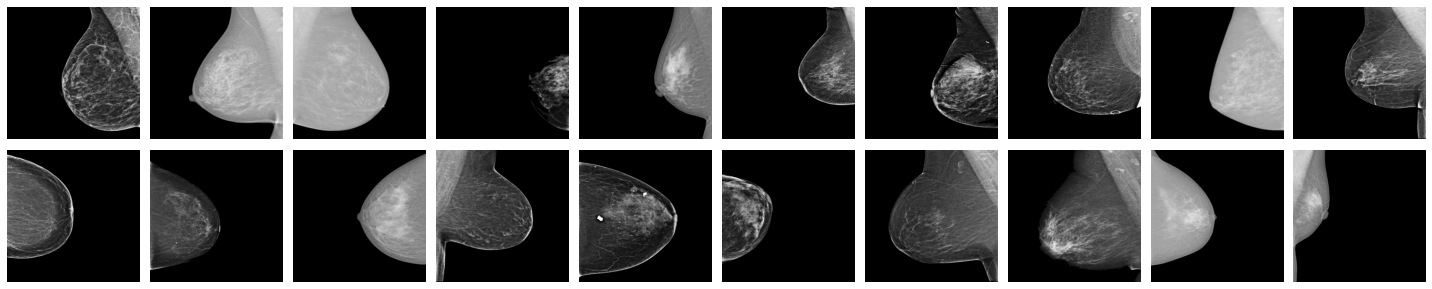

In [29]:
make_plot(x[:20]) 

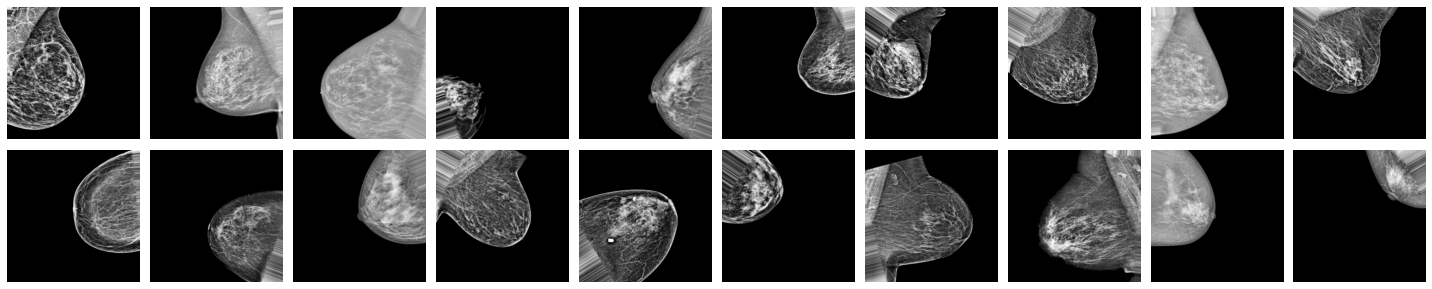

In [30]:
make_plot(aug_x[:20]) 

#Setup Model

In [31]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import applications

In [32]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = callbacks.LearningRateScheduler(lrfn, verbose=True)
    return lr_callback

#Binary Focal Crossentropy

In [33]:
# ref...tf/keras/losses/BinaryFocalCrossentropy
def binary_focal_loss(
    alpha=0.25, 
    gamma=2.0, 
    label_smoothing=0, 
    from_logits=False,
    apply_class_balancing=False,
    apply_bce_weight=1,
    reduction="mean"
):
    '''
    alpha: A weight balancing factor for class 1, default is 0.25. 
        The weight for class 0 is 1.0 - alpha.
    
    gamma: A focusing parameter used to compute the focal factor, default is 2.0
    
    apply_class_balancing: A bool, whether to apply weight balancing on the binary 
        classes 0 and 1.
    '''
    
    def smooth_labels(labels):
        return labels * (1.0 - label_smoothing) + 0.5 * label_smoothing
    
    def compute_loss(labels, logits):
        logits = tf.convert_to_tensor(logits)
        labels = tf.cast(labels, logits.dtype)
        labels = tf.cond(
            tf.cast(label_smoothing, dtype=tf.bool),
            lambda: smooth_labels(labels),
            lambda: labels,
        )
        num_samples = tf.cast(tf.shape(labels)[-1], dtype=labels.dtype)
        cross_entropy = weighted_binary_loss(
            apply_bce_weight, from_logits, reduction='none'
        )(labels, logits)
        
        sigmoidal = tf.cond(
            tf.cast(from_logits, dtype=tf.bool),
            lambda: tf.nn.sigmoid(logits),
            lambda: logits,
        )
        pt = labels * sigmoidal + (1.0 - labels) * (1.0 - sigmoidal)
        focal_factor = tf.pow(1.0 - pt, gamma)
        focal_bce =  focal_factor * cross_entropy
        
        if apply_class_balancing:
            weight = labels * alpha + (1 - labels) * (1 - alpha)
            focal_bce = weight * focal_bce

        if reduction == 'mean':
            return tf.reduce_mean(focal_bce)
        elif reduction == 'sum':
            return tf.reduce_sum(focal_bce) / num_samples
        else:
            raise ValueError(
                'Reduction type should be `mean` or `sum` ',
                f'But, received {reduction}'
            )
    return compute_loss

#Weighted Binary Loss

In [34]:
def weighted_binary_loss(weight, from_logits=True, reduction="mean"):
    def inverse_sigmoid(sigmoidal):
        return - tf.math.log(1. / sigmoidal - 1.)

    def weighted_loss(labels, predictions):
        predictions = tf.convert_to_tensor(predictions)
        labels = tf.cast(labels, predictions.dtype)
        num_samples = tf.cast(tf.shape(labels)[-1], dtype=labels.dtype)

        logits = tf.cond(
            tf.cast(from_logits, dtype=tf.bool),
            lambda: predictions,
            lambda: inverse_sigmoid(sigmoidal=predictions),
        )
        loss = tf.nn.weighted_cross_entropy_with_logits(
            tf.cast(labels, dtype=tf.float32), logits, pos_weight=weight
        )
        
        if reduction.lower() == "mean":
            return tf.reduce_mean(loss)
        elif reduction.lower() == "sum":
            return tf.reduce_sum(loss) / num_samples
        elif reduction.lower() == "none":
            return loss
        else:
            raise ValueError(
                'Reduction type is should be `mean` or `sum` or `none`. ',
                f'But, received {reduction}'
            )
    return weighted_loss

# Probabilistic F Score

In [37]:
def tf_pfbeta(from_logits=True, beta=1.0, epsilon=1e-07):
    
    def pfbeta(y_true, y_pred):
        y_pred = tf.cond(
            tf.cast(from_logits, dtype=tf.bool),
            lambda: tf.nn.sigmoid(y_pred),
            lambda: y_pred,
        )
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        ctp = tf.reduce_sum(y_true * y_pred, axis=-1)
        cfp = tf.reduce_sum(y_pred, axis=-1) - ctp

        c_precision = ctp / (ctp + cfp)
        c_recall = ctp / tf.reduce_sum(y_true)
        
        def compute_fractions():
            numerator = c_precision * c_recall
            denominator = beta**2 * c_precision + c_recall
            return (1 + beta**2) * tf.math.divide_no_nan(numerator, denominator)
        
        return tf.cond(
            tf.logical_and(
                tf.greater(c_precision, 0.), tf.greater(c_recall, 0.)
            ),
            compute_fractions,
            lambda: tf.constant(0, dtype=tf.float32)
        )
    
    return pfbeta

In [38]:
def tf_auc(from_logits=True):
    auc_fn = metrics.AUC()
    
    def auc(y_true, y_pred):
        y_pred = tf.cond(
            tf.cast(from_logits, dtype=tf.bool),
            lambda: tf.nn.sigmoid(y_pred),
            lambda: y_pred,
        )
        return auc_fn(y_true, y_pred)
    
    return auc

#Model

In [41]:
# Resets all state generated by Keras, if.
keras.backend.clear_session()

# Open a strategy scope.
with strategy.scope():
    model = keras.Sequential(
        [
            keras.layers.InputLayer(input_shape=INP_SIZE+(3,)),
            data_preprocessing,
            data_augmentations,
            #applications.EfficientNetB0(include_top=False, pooling='avg'),
            applications.EfficientNetV2S(include_top=False,pooling = 'avg',weights='/content/21_ft1k_notop/efficientnetv2-s-21k-ft1k_notop.h5'),
            keras.layers.Dense(1, activation=None, dtype='float32')
        ]
    )

    model.compile(
        optimizer = tfa.optimizers.RectifiedAdam(learning_rate=0.003, amsgrad=False),  
        loss = binary_focal_loss(
            apply_class_balancing=True, 
            apply_bce_weight=5,  
            alpha=0.75, 
            gamma=7.0,
            label_smoothing=0.05,
            from_logits=True,
            reduction='mean'
        ), 
        metrics = [
            tf_pfbeta(beta=1.0, from_logits=True),
            tf_auc(from_logits=True),
        ]
    )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 PreprocessingLayers (Sequen  (None, 512, 512, 3)      0         
 tial)                                                           
                                                                 
 AugmentationLayers (Sequent  (None, None, None, 3)    0         
 ial)                                                            
                                                                 
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 20,332,641
Trainable params: 20,178,769
Non-trainable params: 153,872
______________________________________

In [42]:
for layer in model.layers:
    print(layer.trainable, layer.name)

True PreprocessingLayers
True AugmentationLayers
True efficientnetv2-s
True dense


In [43]:
CheckPoint = os.path.join(
    'ValidationFold' + str(Config.data.fold), 
    model.layers[2].name.capitalize()
)

training_callbacks = [
    get_lr_callback(BATCH_SIZE),
    callbacks.ModelCheckpoint(
       filepath=CheckPoint + '-model.{epoch:02d}-{val_loss:.4f}-{val_pfbeta:.4f}.h5',
       monitor='val_pfbeta',
       mode='max',
       save_best_only=True
   ),
   callbacks.CSVLogger('history.csv')
]

In [44]:
model.fit(
    training_dataset, 
    validation_data=valid_dataset, 
    epochs=EPOCHS,
    callbacks=training_callbacks
)


Epoch 1: LearningRateScheduler setting learning rate to 5e-06.
Epoch 1/15


1366/1366 [==============================] - 660s 357ms/step - loss: 0.0040 - pfbeta: 0.0386 - auc: 0.5248 - val_loss: 0.0038 - val_pfbeta: 0.0351 - val_auc: 0.5298 - lr: 5.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 1.2e-05.
Epoch 2/15
1366/1366 [==============================] - 472s 346ms/step - loss: 0.0023 - pfbeta: 0.0384 - auc: 0.5242 - val_loss: 0.0019 - val_pfbeta: 0.0348 - val_auc: 0.5277 - lr: 1.2000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9e-05.
Epoch 3/15
1366/1366 [==============================] - 462s 338ms/step - loss: 0.0017 - pfbeta: 0.0388 - auc: 0.5345 - val_loss: 0.0017 - val_pfbeta: 0.0352 - val_auc: 0.5401 - lr: 1.9000e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.6000000000000002e-05.
Epoch 4/15
1366/1366 [==============================] - 460s 337ms/step - loss: 0.0016 - pfbeta: 0.0388 - auc: 0.5445 - val_loss: 0.0016 - val_pfbeta: 0.0352 - val_auc: 0.5484 - lr: 2.6000e-05

Epoch 5: LearningRateSche

In [45]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, INP_SIZE)
    img = tf.cast(img, dtype = tf.float32)
    img = img/255.0
    return img

test_image_paths = []
test_dir = os.listdir('/content/drive/MyDrive/Breast_Cancer_Detection/test_img')
for i in range(len(test_dir)):
    img_path = '/content/drive/MyDrive/Breast_Cancer_Detection/test_img' + '/' + test_dir[i]
    test_image_paths.append(img_path)
test_img_path_ds = tf.data.Dataset.from_tensor_slices(test_image_paths)
test_ds = test_img_path_ds.map(load_image, num_parallel_calls = AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [46]:
preds = model.predict(test_ds)

1/1 [==============================] - 14s 14s/step


In [47]:
preds

array([[-0.57840544],
       [-0.5782807 ],
       [-0.5782807 ],
       [-0.57843906]], dtype=float32)

In [48]:
df = pd.read_csv("/content/drive/MyDrive/Breast_Cancer_Detection/test.csv")
df['cancer'] = 0

THRESHOLD = 0.10

#preds = np.mean([prediction], 0)
preds = (preds > THRESHOLD).astype(int)
df["cancer"] = preds

In [49]:
df['prediction_id'] = df['patient_id'].astype(str) + "_" + df['laterality']

sub = df[['prediction_id', 'cancer']].groupby("prediction_id").mean().reset_index()

sub.to_csv('submission.csv', index=False)

sub.head()

,prediction_id,cancer
0,10008_L,0.0
1,10008_R,0.0
